/opt/anaconda3/envs/igor/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 12510 (\N{KATAKANA LETTER MA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/igor/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 12473 (\N{KATAKANA LETTER SU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/igor/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 12463 (\N{KATAKANA LETTER KU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/igor/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 32080 (\N{CJK UNIFIED IDEOGRAPH-7D50}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/igor/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 26524 (\N{CJK UNIFIED IDEOGRAPH-679C}) 

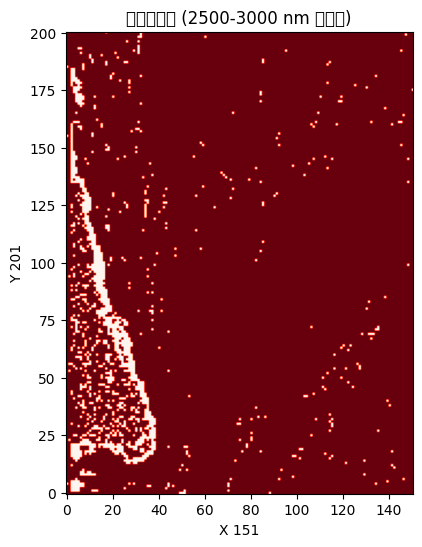

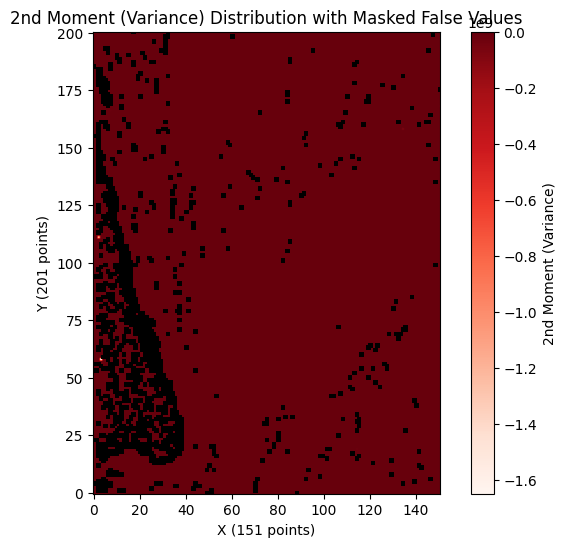

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.ma as ma  # Masked array handling
from my_func.Read_ibw import read_ibw

# ベースライン補正
def subtract_baseline_between_two_wavelengths(wavelengths, spectrum, wavelength1, wavelength2):
    """
    指定した2つの波長間に直線ベースラインを引き、その直線をスペクトルから引く
    wavelengths: 波長の配列
    spectrum: スペクトルデータ
    wavelength1: 1つ目の波長 (波長の値)
    wavelength2: 2つ目の波長 (波長の値)
    """
    # スペクトルをコピーして書き込み可能にする
    spectrum_copy = spectrum.copy()

    # 指定した波長に最も近いインデックスを取得
    point1 = np.abs(wavelengths - wavelength1).argmin()
    point2 = np.abs(wavelengths - wavelength2).argmin()

    # 2点間の波長と強度を取得
    x1, x2 = wavelengths[point1], wavelengths[point2]
    y1, y2 = spectrum_copy[point1], spectrum_copy[point2]

    # 一次関数の傾きと切片を計算 (y = ax + b)
    a = (y2 - y1) / (x2 - x1)
    b = y1 - a * x1

    # 2点間の直線を引き、その直線をスペクトルから引く
    for i in range(point1, point2 + 1):
        baseline = a * wavelengths[i] + b
        spectrum_copy[i] -= baseline

    return spectrum_copy

# データの読み込み
imchi3_data = read_ibw('/Users/ootahiroki/Library/CloudStorage/Box-Box/KanoLab/Raman/data/1008H38_151_201_imchi3_dataOrig.ibw')
imchi3_data = np.moveaxis(imchi3_data, 0, -1)  # 新しい形状: (151, 201, 1, 1148)

wavelengths = read_ibw('/Users/ootahiroki/Library/CloudStorage/Box-Box/KanoLab/Raman/data/1008H38_151_201_re_ramanshift2.ibw')

# マスク処理に使う波長範囲を指定
min_wavelength = 2500  # 最小波長（nm）
max_wavelength = 3000  # 最大波長（nm）

# 指定した波長範囲に対応するインデックスを取得
wavelength_indices = np.where((wavelengths >= min_wavelength) & (wavelengths <= max_wavelength))[0]

# 強度の総和を計算（指定した波長範囲のみ）
intensity_sum = np.sum(imchi3_data[:, :, :, wavelength_indices], axis=-1)  # 形状: (151, 201)

# 閾値に基づくマスクの作成
threshold = -10  # データに応じて調整
mask = intensity_sum > threshold  # 形状: (151, 201, 1)

# マスクの形状を調整（z軸を削除して2次元にする）
mask_2d = mask[:, :, 0] if mask.shape[-1] == 1 else mask

# マスク結果の表示
plt.figure(figsize=(8, 6))
plt.imshow(mask_2d.T, cmap='Reds', origin='lower')
plt.title(f'マスク結果 ({min_wavelength}-{max_wavelength} nm の範囲)')
plt.xlabel('X 151')
plt.ylabel('Y 201')
plt.show()

# ベースライン補正範囲の指定
baseline_min_wavenumber = 1600
baseline_max_wavenumber = 1720

# 2次モーメント（分散）を保存する配列を作成 (151x201の形状に対応)
moment2_map = np.full((imchi3_data.shape[0], imchi3_data.shape[1]), np.nan)  # NaNで初期化

# ベースラインを引いた後にマスクがTrueの箇所に対してのみ2次モーメントを計算
for x in range(imchi3_data.shape[0]):
    for y in range(imchi3_data.shape[1]):
        if mask_2d[x, y]:  # マスクがTrueの箇所のみ
            spectrum = imchi3_data[x, y, 0, :].copy()  # スペクトルデータのコピーを取得
            baseline_subtracted_spectrum = subtract_baseline_between_two_wavelengths(wavelengths, spectrum, baseline_min_wavenumber, baseline_max_wavenumber)

            # 1次モーメント（平均）を計算
            range_mask = (wavelengths >= baseline_min_wavenumber) & (wavelengths <= baseline_max_wavenumber)
            spectrum_in_range = baseline_subtracted_spectrum[range_mask]
            wavelengths_in_range = wavelengths[range_mask]
            moment1_value = np.sum(spectrum_in_range * wavelengths_in_range) / np.sum(spectrum_in_range)

            # 2次モーメント（分散）の計算
            moment2_value = np.sum(spectrum_in_range * (wavelengths_in_range - moment1_value)**2) / np.sum(spectrum_in_range)

            # 2次モーメントをマップに反映
            moment2_map[x, y] = moment2_value

# マスクされたエリアをNaNで区別した状態で表示するためにMasked Arrayを使用
masked_moment2_map = ma.masked_invalid(moment2_map)

# ヒートマップの表示
plt.figure(figsize=(8, 6))
cmap = plt.cm.Reds  # カラーマップを設定
cmap.set_bad(color='black')  # マスクされた箇所 (NaN) を黒に設定

# カラーバー付きのヒートマップ表示
plt.imshow(masked_moment2_map.T, cmap=cmap, origin='lower')
plt.colorbar(label='2nd Moment (Variance)')
plt.title('2nd Moment (Variance) Distribution with Masked False Values')
plt.xlabel('X (151 points)')
plt.ylabel('Y (201 points)')
plt.grid(False)
plt.show()
